In [5]:
import pandas as pd
import yfinance as yf
df = yf.download("AAPL", interval="1d", progress = False)
index_of_zero_volume = df[df['Volume'] == 0].index
df.drop(index_of_zero_volume, inplace=True)

In [6]:
#Check if any zero volumes are available
indexZeros = df[ df['Volume'] == 0 ].index

df.drop(indexZeros , inplace=True)
df.loc[(df["Volume"] == 0 )]
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
import numpy as np
import pandas_ta as ta
#df.ta.indicators()
#help(ta.atr)
df['ATR'] = df.ta.atr(length=20)
df['RSI'] = df.ta.rsi()
df['Average'] = df.ta.midprice(length=1) #midprice
df['MA40'] = df.ta.sma(length=40)
df['MA80'] = df.ta.sma(length=80)
df['MA160'] = df.ta.sma(length=160)

from scipy.stats import linregress
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
backrollingN = 6
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df['slopeMA40'] = df['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA80'] = df['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA160'] = df['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['AverageSlope'] = df['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['RSISlope'] = df['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

# Target categories

In [8]:
#Target flexible way
# pipdiff = 500*1e-5 #for TP
 #pipdiff/Ratio gives SL

def mytarget(barsupfront, df1):
    SLTPRatio = 2
    length = len(df1)
    high = list(df1['High'])
    low = list(df1['Low'])
    close = list(df1['Close'])
    open = list(df1['Open'])
    trendcat = [None] * length
    
    for line in range (0,length-barsupfront-2):
        pipdiff = close[line+1]*0.1
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

barsupfront = 16

=> 

In [10]:
# mytarget(barsfront to take into account, dataframe)

df['mytarget'] = mytarget(16, df)

# Quick analysis example

C:\Users\p3749\AppData\Local\Temp\ipykernel_31152\532070288.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_model.hist(ax = ax)


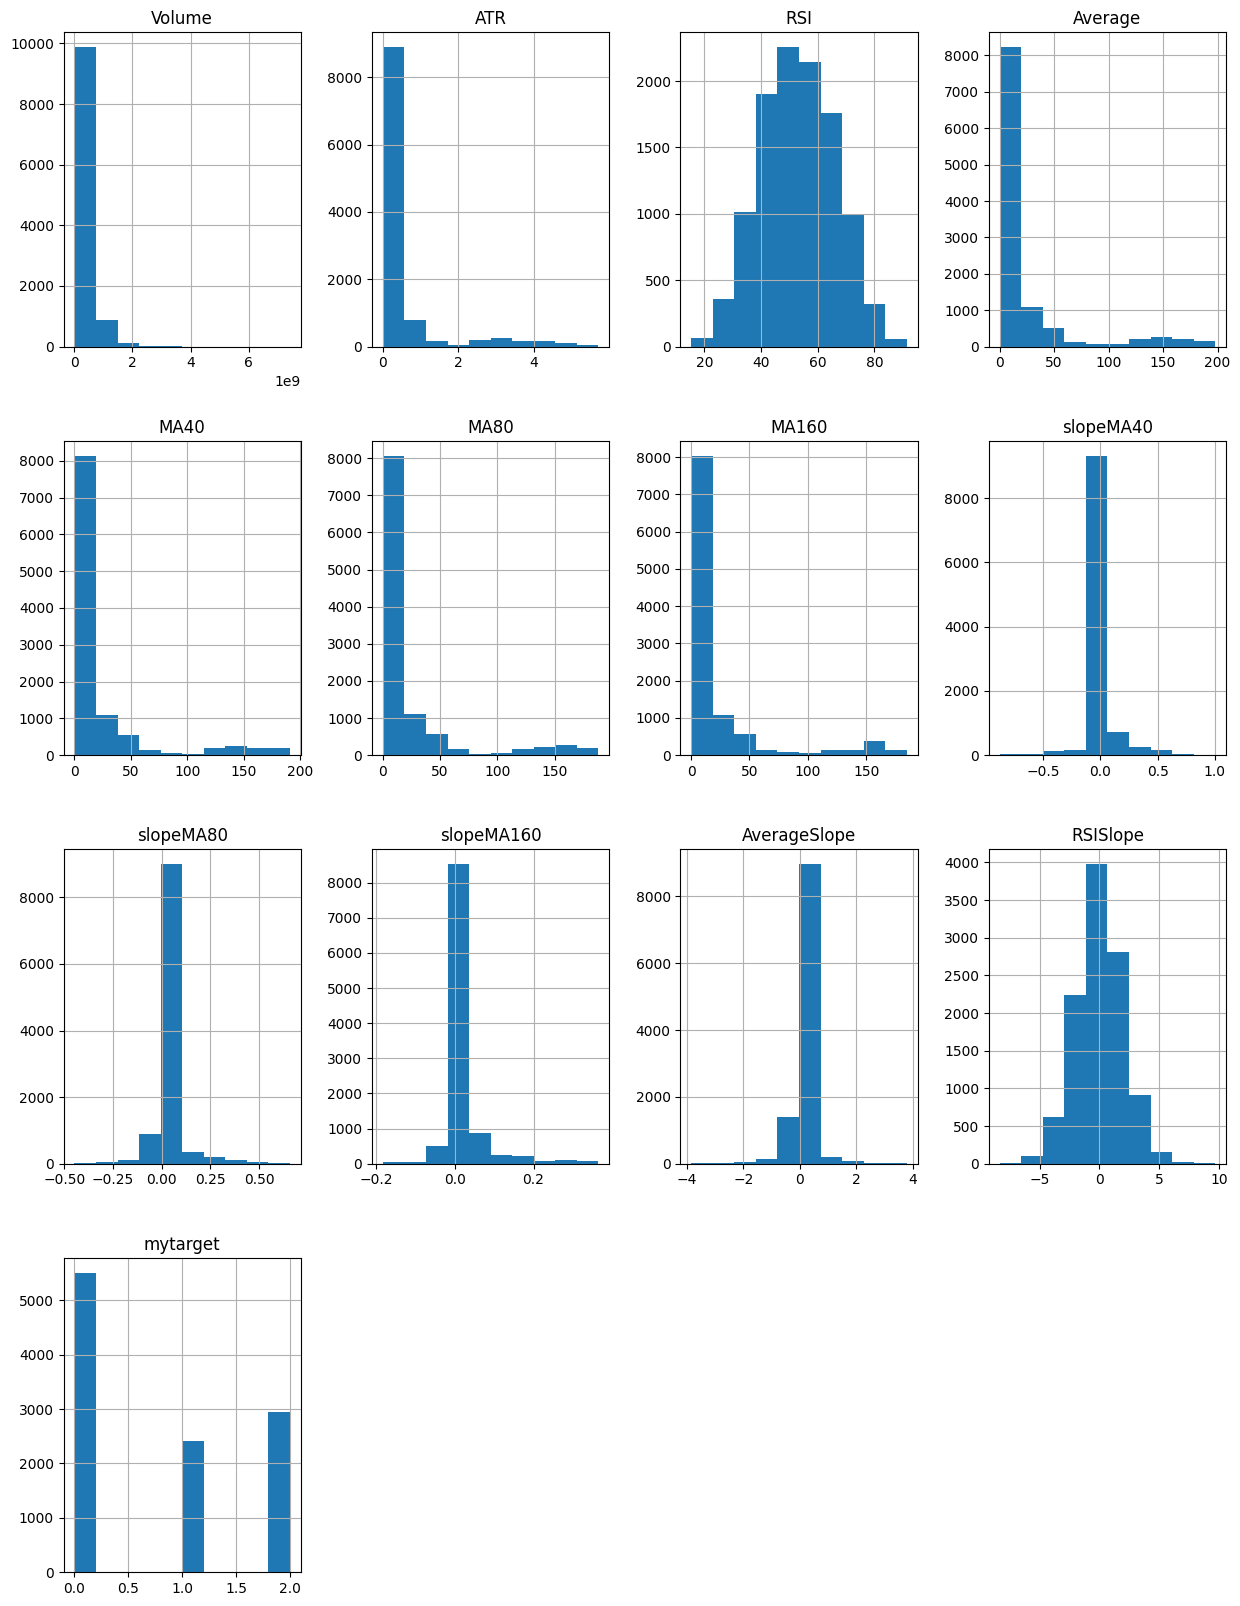

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_model= df[['Volume', 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope', 'mytarget']] 
df_model.hist(ax = ax)
plt.show()

## Can we use the RSI alone as a trend indicator?

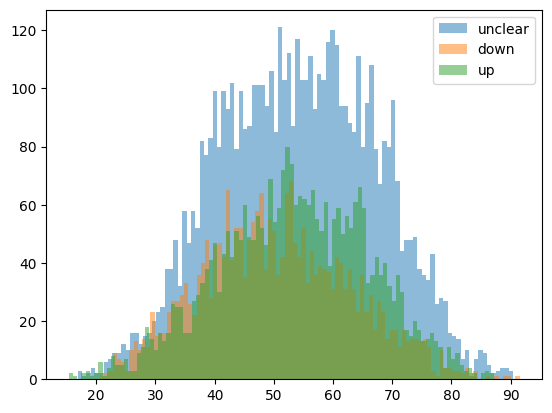

In [12]:
from matplotlib import pyplot
df_up=df.RSI[ df['mytarget'] == 2 ]
df_down=df.RSI[ df['mytarget'] == 1 ]
df_unclear=df.RSI[ df['mytarget'] == 0 ]
pyplot.hist(df_unclear, bins=100, alpha=0.5, label='unclear')
pyplot.hist(df_down, bins=100, alpha=0.5, label='down')
pyplot.hist(df_up, bins=100, alpha=0.5, label='up')

pyplot.legend(loc='upper right')
pyplot.show()

# Machine learning for trend prediction

## 1 - the perfect model with precise prediction

## 2 - less perfect model still with > 40% precision

## 3 - much less perfect model with precision >35% taking into account our strategy, and our TP/SL ratio 

### can't let an automated program run your trades
### it can be your version of a smart indicator (based on machine learning)

## 4 - Our target has categorical values so we need a classificator, KNN?

## Splitting features and target

In [13]:
df_model=df_model.dropna()

attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
X = df_model[attributes]
y = df_model["mytarget"]

print(X)

                 ATR        RSI     Average        MA40        MA80  \
Date                                                                  
1981-08-07  0.003475  49.453823    0.113002    0.117425    0.124030   
1981-08-11  0.003469  45.517228    0.109933    0.116532    0.123919   
1981-08-12  0.003407  43.056557    0.107422    0.115597    0.123863   
1981-08-13  0.003404  39.598498    0.104074    0.114648    0.123723   
1981-08-14  0.003317  37.957005    0.102679    0.113714    0.123465   
...              ...        ...         ...         ...         ...   
2024-01-23  3.187795  62.619641  194.790001  190.815000  184.640001   
2024-01-24  3.130405  60.919755  195.360001  190.928250  184.937626   
2024-01-25  3.131885  60.067547  194.690002  191.037750  185.224625   
2024-01-26  3.116291  55.623750  193.349998  191.088250  185.458000   
2024-01-29  3.102476  53.929650  190.889999  191.147250  185.699625   

                 MA160  slopeMA40  slopeMA80  slopeMA160  AverageSlope  \
Da

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Fitting the KNN model

In [15]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=200, weights='uniform', algorithm='kd_tree', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=1)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

## Quick evaluation of our fitting

In [16]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy test: %.2f%%" % (accuracy_test * 100.0))

#------------------------------------------------------------------
#--- How should I compare my accuracy ?
print(df_model['mytarget'].value_counts()*100/df_model['mytarget'].count())

# Random Model, gambler?
pred_test = np.random.choice([0, 1, 2], len(y_pred_test))
accuracy_test = accuracy_score(y_test, pred_test)
print("Accuracy Gambler: %.2f%%" % (accuracy_test * 100.0))

Accuracy train: 52.36%
Accuracy test: 48.88%
mytarget
0.0    50.882600
2.0    27.169142
1.0    21.948258
Name: count, dtype: float64
Accuracy Gambler: 32.26%


## More powerful model XGBoost

In [17]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

pred_test = np.random.choice([0, 1, 2], len(y_pred_test))
accuracy_test = accuracy_score(y_test, pred_test)
print("Accuracy Gambler: %.2f%%" % (accuracy_test * 100.0))

****Train Results****
Accuracy: 96.5674%
****Test Results****
Accuracy: 75.8637%
Accuracy Gambler: 33.75%


## !!Data sampling shouldn't be random

In [101]:
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import numpy as np
df = yf.download("SBUX", interval="1d", progress = False)
index_of_zero_volume = df[df['Volume'] == 0].index
df.drop(index_of_zero_volume, inplace=True)

df['ATR'] = df.ta.atr(length=20)
df['RSI'] = df.ta.rsi()
df['Average'] = df.ta.midprice(length=1) #midprice
df['MA40'] = df.ta.sma(length=40)
df['MA80'] = df.ta.sma(length=80)
df['MA160'] = df.ta.sma(length=160)

from scipy.stats import linregress
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
backrollingN = 6
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df['slopeMA40'] = df['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA80'] = df['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA160'] = df['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['AverageSlope'] = df['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['RSISlope'] = df['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

def mytarget(barsupfront, df1):
    SLTPRatio = 2
    length = len(df1)
    high = list(df1['High'])
    low = list(df1['Low'])
    close = list(df1['Close'])
    open = list(df1['Open'])
    trendcat = [None] * length
    
    for line in range (0,length-barsupfront-2):
        pipdiff = close[line+1]*0.1
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat
df['mytarget'] = mytarget(16, df)

df_model= df[['Volume', 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope', 'mytarget']] 
df_model=df_model.dropna()

attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
X = df_model[attributes]
y = df_model["mytarget"]

X = df_model[["RSI", "ATR", "MA40"]]

#sequential sampling
train_index = int(0.8 * len(X))
X_train, X_test = X[:train_index], X[train_index:]
y_train, y_test = y[:train_index], y[train_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))
dfp1 = df.iloc[-len(pred_test):, :]

pred_points = []
for i in range(len(pred_test)):
    if pred_test[i]==2:
        pred_points.append(dfp1['Low'][i]*0.98)
    elif pred_test[i]==1:
        pred_points.append(dfp1['High'][i]*1.02)
    else:
        pred_points.append(np.nan)

****Train Results****
Accuracy: 93.3890%
****Test Results****
Accuracy: 52.3412%


In [102]:
k = 365
dfp1 = dfp1.iloc[-k:, :]
fig = go.Figure(data=[go.Candlestick(x=dfp1.index, 
                open=dfp1["Open"],
                high=dfp1['High'],
                low=dfp1['Low'],
                close=dfp1['Close']),
                ])
fig.add_trace(go.Scatter(x=dfp1.index, y=dfp1["MA40"], mode='lines', name='ATR'))

fig.add_scatter(x=dfp1.index, y=pred_points[-k:], mode='markers',
                marker=dict(size=3, color="MediumPurple"), name='entry')
fig.show()

In [100]:
list(pred_test).count(2)

11

In [57]:
pred_points = []
for i in range(len(pred_test)):
    if pred_test[i]==2:
        pred_points.append(dfp1['Low'][i] - 10)
    elif pred_test[i]==1:
        pred_points.append(dfp1['High'][i] + 10)
    else:
        pred_points.append(np.nan)

dfp1 = dfp1.iloc[-365:, :]
fig = go.Figure(data=[go.Candlestick(x=dfp1.index, 
                open=dfp1["Open"],
                high=dfp1['High'],
                low=dfp1['Low'],
                close=dfp1['Close']),
                ])
fig.add_scatter(x=dfp1.index, y=pred_points[-365:], mode='markers',
                marker=dict(size=3, color="MediumPurple"), name='entry')
fig.show()

IndexError: index 636 is out of bounds for axis 0 with size 365

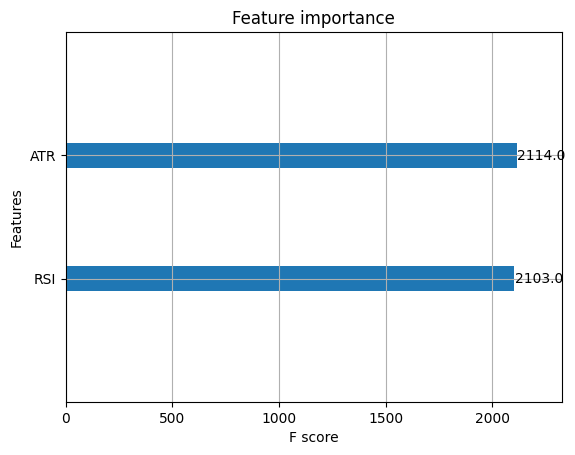

In [76]:
from matplotlib import pyplot
from xgboost import plot_importance
#plot feature importance
plot_importance(model)
pyplot.show()